<a href="https://colab.research.google.com/github/hyooz-Kang/Hmm2Song/blob/subeen/3.%20modeling_cosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. settings**

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm
import pandas as pd
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

### GPU 사용 여부 체크
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training.")

Using cuda for training.


# **2. Preparing Data**
- 원곡 음원과 허밍 음원(변형된 음원)의 mel 벡터를 데이터프레임에 매칭
  - 각 음원 조각별로 5가지의 변형
- train_map 리스트에 각 원본 음원과 허밍 음원의 경로를 튜플로 저장

## **2-1. Load & Map Data**

In [ ]:
### 곡 번호 가져오기

input_path = '/content/drive/MyDrive/Hmm2Song/data/song/Split_input/'

files = os.listdir(input_path)
mp3_files = [f for f in files if f.endswith(".mp3")]
mp3_files = sorted(mp3_files)

# 곡 번호 추출
numbers = []
for f in mp3_files:
  # Split the filename by "/"
  parts = f.split("/")
  # Get the last part of the filename, which is the ID
  number = parts[-1].split("_")[0]
  numbers.append(number)

In [ ]:
### 데이터 파일 경로 설정

org_path = '/content/drive/MyDrive/Hmm2Song/data/song/org.npy'
fh_path = '/content/drive/MyDrive/Hmm2Song/data/song/fh.npy'
fl_path = '/content/drive/MyDrive/Hmm2Song/data/song/fl.npy'
mh_path = '/content/drive/MyDrive/Hmm2Song/data/song/mh.npy'
ml_path = '/content/drive/MyDrive/Hmm2Song/data/song/ml.npy'
n_path = '/content/drive/MyDrive/Hmm2Song/data/song/n.npy'

In [ ]:
### 원곡 & 허밍 데이터 로드
org = np.load(org_path, allow_pickle = True)
fh = np.load(fh_path, allow_pickle = True)
fl = np.load(fl_path, allow_pickle = True)
mh = np.load(mh_path, allow_pickle = True)
ml = np.load(ml_path, allow_pickle = True)
n = np.load(n_path, allow_pickle = True)

In [ ]:
### 데이터프레임 생성
data = {
    'song_no': numbers,
    'org': org,
    'fh': fh,
    'fl': fl,
    'mh': mh,
    'ml': ml,
    'n': n
}

music = pd.DataFrame(data)
music.head()

,song_no,org,fh,fl,mh,ml,n
0,000,"[[-53.434498, -53.434498, -53.434498, -53.4344...","[[-64.46365, -64.46365, -64.46365, -64.46365, ...","[[-53.462494, -53.462494, -53.462494, -53.4624...","[[-55.8885, -55.8885, -55.8885, -55.8885, -55....","[[-55.95763, -55.95763, -55.95763, -55.95763, ...","[[-9.18961, -8.082821, -10.054024, -9.653147, ..."
1,000,"[[-11.306869, -10.583914, -13.366933, -14.5223...","[[-33.90235, -39.70997, -57.306282, -57.306282...","[[-11.283159, -10.587484, -13.5872135, -14.666...","[[-12.906219, -11.651057, -14.351291, -15.2013...","[[-10.752398, -10.82634, -14.578722, -15.97892...","[[-5.086788, -5.206139, -11.650671, -7.4844594..."
2,000,"[[-7.9065266, -10.674957, -13.891659, -20.9580...","[[-44.07569, -49.08165, -47.601494, -48.4676, ...","[[-8.294864, -10.802288, -13.778696, -21.03367...","[[-9.173194, -13.967354, -21.154625, -29.20704...","[[-6.0015, -9.459395, -13.348994, -20.772518, ...","[[-4.316294, -7.043939, -8.572198, -9.052606, ..."
3,000,"[[20.618156, 21.427076, 19.18558, 13.680927, 3...","[[-30.319366, -31.61372, -34.726913, -40.04141...","[[20.610598, 21.41199, 19.180431, 13.631516, 3...","[[16.674326, 14.218125, 11.978937, 7.5957184, ...","[[23.048532, 24.449047, 21.363308, 15.357315, ...","[[20.633581, 21.456093, 19.215803, 13.742048, ..."
4,000,"[[-16.27028, -21.62627, -47.989334, -50.855732...","[[-45.3732, -53.73243, -59.59111, -59.59111, -...","[[-14.381916, -19.772512, -47.65141, -51.05184...","[[-19.572826, -24.678566, -46.37851, -52.57517...","[[-15.229172, -20.558203, -43.36681, -43.05114...","[[-6.430007, -8.372921, -9.389027, -9.194475, ..."


각각의 곡에 대해 원곡과 허밍된 음성의 mel 값이 벡터 형태로 넘어온다.


In [ ]:
len(music)

22730

## **2-2. Train/Test Split**
- train의 경우 각 원본 음원과 허밍 음원의 mel 벡터를 쌍으로 매칭해 튜플로 저장
- test의 경우 mel 벡터만 저장

In [ ]:
def make_train_test(df, random_seed = 42):

    np.random.seed(random_seed)

    train_maps, test_li = [], []

    for index, row in df.iterrows():
        test_hum_col = np.random.choice(['fh', 'fl', 'mh', 'ml', 'n'])
        test = row[test_hum_col]
        test_li.append(test)

        train_hum_cols = list(set(['fh', 'fl', 'mh', 'ml', 'n']) - {test_hum_col})
        for train_hum_col in train_hum_cols:
            train_map = (row['org'], row[train_hum_col])
            train_maps.append(train_map)

    return train_maps, test_li

In [ ]:
train_map, test = make_train_test(music, random_seed = 42)

In [ ]:
train_map[0]

(array([[-53.434498 , -53.434498 , -53.434498 , ..., -11.491163 ,
         -19.790825 ,  -4.282523 ],
        [-53.434498 , -53.434498 , -53.434498 , ...,  -6.7589192,
         -10.0783825,  -3.128749 ],
        [-53.434498 , -53.434498 , -53.434498 , ...,  -6.1969037,
          -9.043031 ,   1.9364727],
        ...,
        [-53.434498 , -53.434498 , -53.434498 , ..., -53.434498 ,
         -53.434498 , -33.53729  ],
        [-53.434498 , -53.434498 , -53.434498 , ..., -53.434498 ,
         -53.434498 , -33.758835 ],
        [-53.434498 , -53.434498 , -53.434498 , ..., -53.434498 ,
         -53.434498 , -35.193287 ]], dtype=float32),
 array([[-55.8885   , -55.8885   , -55.8885   , ..., -16.854303 ,
         -18.92465  , -10.810755 ],
        [-55.8885   , -55.8885   , -55.8885   , ..., -15.1059   ,
         -19.543844 , -11.441732 ],
        [-55.8885   , -55.8885   , -55.8885   , ...,  -7.560642 ,
         -10.973306 ,  -5.6860375],
        ...,
        [-55.8885   , -55.8885   , -55.

In [ ]:
train_map[0][0].shape

(128, 431)

In [ ]:
test[0]

array([[-55.95763  , -55.95763  , -55.95763  , ..., -13.875435 ,
        -15.662851 ,  -5.4593253],
       [-55.95763  , -55.95763  , -55.95763  , ...,  -7.1582246,
        -11.020405 ,  -2.7339075],
       [-55.95763  , -55.95763  , -55.95763  , ...,   6.5668344,
          6.6708145,   6.1347055],
       ...,
       [-55.95763  , -55.95763  , -55.95763  , ..., -55.95763  ,
        -52.45276  , -37.819366 ],
       [-55.95763  , -55.95763  , -55.95763  , ..., -55.95763  ,
        -53.005585 , -37.424305 ],
       [-55.95763  , -55.95763  , -55.95763  , ..., -55.95763  ,
        -55.95763  , -40.89798  ]], dtype=float32)

In [ ]:
test[0].shape

(128, 431)

# **3. Dataset**
- 데이터셋을 정의하고 로드하는 과정
- Triplet Loss를 계산하기 위한 triplet dataset 생성
- PyTorch의 `Dataset` 클래스를 상속받아 트리플렛 데이터셋을 구현
- 원본 음원, 변형된 음원, 부정적 예제로 이루어진 트리플렛 쌍을 제공
  - 각 샘플은 anchor(허밍), positive(원곡), negative(다른곡)의 세 부분으로 구성됨

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F

In [ ]:
### 스펙트로그램 불러오기
## 128: 주파수, 431: 시간 스텝 수

def load_spectrogram(spectrogram):
  if not isinstance(spectrogram, torch.Tensor):
    spectrogram = torch.tensor(spectrogram)
  if spectrogram.shape != (128, 431): # 길이가 짧게 잘린 음원에 패딩을 0으로 넣어 모양을 맞춰줌
    pad = (0, 431 - spectrogram.shape[1])
    spectrogram = F.pad(spectrogram, pad, "constant", 0)

  return spectrogram

In [ ]:
class MusicTripletDataset(Dataset):

  ### 클래스를 초기화하고 데이터셋의 정보를 설정
  def __init__(self, music_files):
    self.music_files = music_files # (원곡, 허밍)

  ### 데이터셋의 전체 길이를 반환
  def __len__(self):
    return len(self.music_files)

  ### 트리플렛 데이터셋 구성
  def __getitem__(self, idx):
    ## 원곡(Positive)과 허밍(Anchor) 데이터 쌍 구성
    positive_file, anchor_file = self.music_files[idx]
    # 스펙트로그램 정보 가져오기
    positive = load_spectrogram(positive_file)
    anchor = load_spectrogram(anchor_file)

    ## 부정(negative) 예제 생성
    # positive가 아닌 것은 모두 부정 예제 -> 임의의 곡을 선택하여 부정 예제로 학습시킴
    negative_idx = np.random.choice([i for i in range(len(self.music_files)) if i != idx])
    negative_file = self.music_files[negative_idx][0] # 다른 곡(-> 원곡) 선택
    negative = load_spectrogram(negative_file)

    return anchor, positive, negative

In [ ]:
### 데이터 준비
train = MusicTripletDataset(train_map)
test = [load_spectrogram(spec) for spec in test]

# 미니배치 단위로 데이터를 효율적으로 불러오기
batch_size = 64
trainloader = DataLoader(train, batch_size = batch_size, shuffle = True)

In [ ]:
### 데이터 shape 확인
anchor, positive, negative = next(iter(trainloader))

print('Anchor shape:', anchor.shape)
print('Positive shape:', positive.shape)
print('Negative shape:', negative.shape)

Anchor shape: torch.Size([64, 128, 431])
Positive shape: torch.Size([64, 128, 431])
Negative shape: torch.Size([64, 128, 431])


batch_size, height(= 주파수), width(= time step)

# **4. Modeling**
- 신경망 모델을 정의하고 훈련하는 부분
  - Triplet Loss를 활용한 학습을 위한 모델 구성 부분
- Triplet Loss는 세 가지 샘플(Anchor, Positive, Negative) 간의 거리 관계를 학습
  - Anchor(허밍)와 Positive(원곡) 간의 거리를 최소화하고, Anchor(허밍)와 Negative(다른곡) 간의 거리를 최대화하는 방식으로 모델을 훈련

In [ ]:
import torch.nn as nn

In [ ]:
### 학습을 위한 모델 구성 부분
## 음원 스펙트로그램에 적합한 합성곱 층과 풀링 층, 그리고 완전 연결 층으로 구성

class ConvSubnet(nn.Module):
  def __init__(self, embedding_dims = 128):
    super(ConvSubnet, self).__init__()
    ## Convolutional Layer
    self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
    ## MaxPooling Layer
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    ## Fully Connected Layer
    # maxpooling을 3번 거치면서 height(128 => 64 -> 32 -> 16), width(431 => 215, 107, 53)
    self.fc = nn.Linear(848, embedding_dims)  # 16 * 53 = 848

  def forward(self, x):
    ## 데이터 차원 조정 -> [batch, channel, height, width]
    x = x.unsqueeze(1)
    ## Convolutional Layer를 통과시켜 특징을 추출하고 활성화 함수를 적용
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    ## 데이터를 1차원으로 펼침
    x = x.view(-1, 848)
    ## FC Layer를 통과시켜 임베딩 생성
    x = self.fc(x)
    return x

In [ ]:
import matplotlib.pyplot as plt

### Loss 시각화 함수
def plot_loss_curve(loss_curve):
  plt.plot(loss_curve, label='Training Loss')
  plt.title('Training Loss Curve')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
### TripletMarginLoss 및 모델 초기화

triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function = nn.CosineSimilarity()) # 코사인 유사도로 거리 측정
model = ConvSubnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
## 모델 가중치 저장
now = datetime.now().strftime('%Y%m%d_%H%M%S')
model_dir = f'/content/drive/MyDrive/Hmm2Song/차수빈/model/{now}/'
os.mkdir(model_dir)

In [ ]:
### 학습 loop 최적화

num_epochs = 5
checkpoint = 1
log_steps = 50
loss_curve = []  # Loss 저장을 위한 리스트

# 모델을 학습 모드로 설정
model.train()

for epoch in range(num_epochs):
  print(f'========== Epoch {epoch + 1} ==========')
  for step, (anchor, positive, negative) in enumerate(trainloader, 1):
    optimizer.zero_grad()

    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
    embedded_anchor, embedded_positive, embedded_negative = model(anchor), model(positive), model(negative)

    loss = triplet_loss(embedded_anchor, embedded_positive, embedded_negative)
    loss.backward()
    optimizer.step()

    loss_curve.append(loss.item())

    if step % log_steps == 0:
      print(f'Epoch {epoch + 1}, Step {step}, Loss: {loss.item()}')

  # 에폭이 끝날 때마다 모델 저장
  if (epoch + 1) % checkpoint == 0:
      torch.save(model.state_dict(), os.path.join(model_dir, f'model_weights_{epoch + 1}.pth'))

  print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
  print()

========== Epoch 1 ==========
Epoch 1, Step 50, Loss: 1.000361680984497
Epoch 1, Step 100, Loss: 1.0001509189605713
Epoch 1, Step 150, Loss: 1.0001165866851807
Epoch 1, Step 200, Loss: 1.000097393989563
Epoch 1, Step 250, Loss: 1.0000646114349365
Epoch 1, Step 300, Loss: 1.0000734329223633
Epoch 1, Step 350, Loss: 1.0000474452972412
Epoch 1, Step 400, Loss: 1.0000462532043457
Epoch 1, Step 450, Loss: 1.000036597251892
Epoch 1, Step 500, Loss: 1.0000317096710205
Epoch 1, Step 550, Loss: 1.0000249147415161
Epoch 1, Step 600, Loss: 1.0000276565551758
Epoch 1, Step 650, Loss: 1.000024437904358
Epoch 1, Step 700, Loss: 1.0000183582305908
Epoch 1, Step 750, Loss: 1.0000152587890625
Epoch 1, Step 800, Loss: 1.0000157356262207
Epoch 1, Step 850, Loss: 1.0000113248825073
Epoch 1, Step 900, Loss: 1.0000122785568237
Epoch 1, Step 950, Loss: 1.0000110864639282
Epoch 1, Step 1000, Loss: 1.000009298324585
Epoch 1, Step 1050, Loss: 1.000009536743164
Epoch 1, Step 1100, Loss: 1.000006914138794
Epoch 1

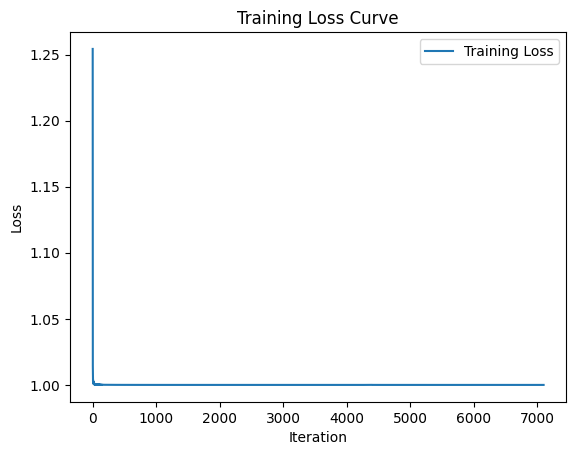

In [ ]:
### loss 시각화

plot_loss_curve(loss_curve)

# **5. Inference**
- 정확도는 모르겠고 추론이란 걸 한 번 해보아요 (oﾟvﾟ)ノ

In [ ]:
# 모델 로딩

model_path = '/content/drive/MyDrive/Hmm2Song/차수빈/model/euron_modeling_5.pth'
model = ConvSubnet().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

ConvSubnet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=848, out_features=128, bias=True)
)

In [ ]:
# info.csv 로딩
song_info = pd.read_csv('/content/drive/MyDrive/Hmm2Song/data/info2.csv')
song_info.head()

,id,Title,Singer,Lyric,genre,path,gender
0,0,To. X,태연 (TAEYEON),처음 본 널 기억해 We skipped the small talk 바로 다음 단계였...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,여성
1,1,Either Way,IVE (아이브),누가 내 말투가 재수없대 잘난 척만 한대 또 누구는 내가 너무 착하대 바보같을 정도...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,여성
2,2,DIE 4 YOU,DEAN,I don’t wanna go Till everything comes crashin...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,남성
3,3,Must Have Love,"SG 워너비, 브라운아이드걸스",함께 있단 이유로 행복했었던 우리들의 겨울날의 소중한 기억들 좋은 날엔 언제나 네가...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,혼성
4,4,Still With You,정국,날 스치는 그대의 옅은 그 목소리 내 이름을 한 번만 더 불러주세요 얼어버린 노을 ...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,남성


In [ ]:
### 데이터형 변경

# id 컬럼을 object 형으로 변경
song_info['id'] = song_info['id'].astype('object')

# id 컬럼을 3자리로 맞춤
song_info['id'] = song_info['id'].apply(lambda x: str(x).zfill(3))

In [ ]:
song_info.head()

,id,Title,Singer,Lyric,genre,path,gender
0,000,To. X,태연 (TAEYEON),처음 본 널 기억해 We skipped the small talk 바로 다음 단계였...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,여성
1,001,Either Way,IVE (아이브),누가 내 말투가 재수없대 잘난 척만 한대 또 누구는 내가 너무 착하대 바보같을 정도...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,여성
2,002,DIE 4 YOU,DEAN,I don’t wanna go Till everything comes crashin...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,남성
3,003,Must Have Love,"SG 워너비, 브라운아이드걸스",함께 있단 이유로 행복했었던 우리들의 겨울날의 소중한 기억들 좋은 날엔 언제나 네가...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,혼성
4,004,Still With You,정국,날 스치는 그대의 옅은 그 목소리 내 이름을 한 번만 더 불러주세요 얼어버린 노을 ...,RnB_Soul,/content/drive/MyDrive/Hmm2Song/data/song/Full...,남성


In [ ]:
### 원곡 음원 임베딩

music_emb = music[['song_no', 'org']]
music_emb['org_emb'] = music_emb['org'].apply(lambda x: load_spectrogram(x))
music_emb.head()

<ipython-input-28-c0985b14037a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_emb['org_emb'] = music_emb['org'].apply(lambda x: load_spectrogram(x))


,song_no,org,org_emb
0,000,"[[-53.434498, -53.434498, -53.434498, -53.4344...","[[tensor(-53.4345), tensor(-53.4345), tensor(-..."
1,000,"[[-11.306869, -10.583914, -13.366933, -14.5223...","[[tensor(-11.3069), tensor(-10.5839), tensor(-..."
2,000,"[[-7.9065266, -10.674957, -13.891659, -20.9580...","[[tensor(-7.9065), tensor(-10.6750), tensor(-1..."
3,000,"[[20.618156, 21.427076, 19.18558, 13.680927, 3...","[[tensor(20.6182), tensor(21.4271), tensor(19...."
4,000,"[[-16.27028, -21.62627, -47.989334, -50.855732...","[[tensor(-16.2703), tensor(-21.6263), tensor(-..."


In [ ]:
### 추론

def infer_with_filtering(model, test_mel, music_df, info_df, user_genre, user_gender):
    with torch.no_grad():
        # 테스트 데이터에 대한 mel 벡터를 모델에 전달하여 임베딩 얻기
        test_embedding = model(test_mel.unsqueeze(0).to(device))

        # 필터링을 위한 데이터프레임 생성
        filtered_info_df = info_df[(info_df['genre'] == user_genre) & (info_df['gender'] == user_gender)]

        if filtered_info_df.empty:  # 필터링된 데이터가 없을 경우
            return None

        # 필터링된 데이터프레임의 id와 song_no를 일치시켜서 필터링된 음악 정보를 가져옴
        filtered_music_df = music_df[music_df['song_no'].isin(filtered_info_df['id'])].reset_index(drop=True)

        # 모든 원곡의 mel 벡터에 대해 임베딩을 계산하고 거리 측정
        distances = []
        for _, row in filtered_music_df.iterrows():
            org_embedding = model(row['org_emb'].unsqueeze(0).to(device))
            cdist = torch.nn.CosineSimilarity()
            dist = cdist(test_embedding, org_embedding).cpu().numpy()
            distances.append(dist)

        if not distances:  # 필터링된 데이터가 없을 경우
            return None

        # 거리가 가장 가까운 원곡의 정보 얻기
        closest_idx = min(range(len(distances)), key=lambda i: distances[i][0])
        closest_song_no = filtered_music_df.loc[closest_idx, 'song_no']

        # 해당 원곡의 정보 얻기
        song_info = info_df.loc[info_df['id'] == closest_song_no].iloc[0]

    return song_info

In [ ]:
test[0]

tensor([[-55.9576, -55.9576, -55.9576,  ..., -13.8754, -15.6629,  -5.4593],
        [-55.9576, -55.9576, -55.9576,  ...,  -7.1582, -11.0204,  -2.7339],
        [-55.9576, -55.9576, -55.9576,  ...,   6.5668,   6.6708,   6.1347],
        ...,
        [-55.9576, -55.9576, -55.9576,  ..., -55.9576, -52.4528, -37.8194],
        [-55.9576, -55.9576, -55.9576,  ..., -55.9576, -53.0056, -37.4243],
        [-55.9576, -55.9576, -55.9576,  ..., -55.9576, -55.9576, -40.8980]])

In [ ]:
# 예시로 첫 번째 허밍된 음성을 사용
test_mel = test[1] # 태연 - To.X

user_genre = input("장르를 입력하세요: ")
user_gender = input("성별을 입력하세요: ")

## 추론 결과 얻기
inferred_info = infer_with_filtering(model, test_mel, music_emb, song_info, user_genre, user_gender)

if inferred_info.any():
    print("== 가장 유사한 원곡 정보 ==")
    print("곡 번호:", inferred_info['id'])
    print("제목:", inferred_info['Title'])
    print("가수:", inferred_info['Singer'])
    print("장르:", inferred_info['genre'])
    print("가수 성별:", inferred_info['gender'])
    print("가사:", inferred_info['Lyric'])
else:
    print("입력한 장르와 성별에 해당하는 음악이 없습니다.")

장르를 입력하세요: RnB_Soul
성별을 입력하세요: 여성
== 가장 유사한 원곡 정보 ==
곡 번호: 091
제목: 아이(I) (Feat. DAWN)
가수: 박봄 (Park Bom)
장르: RnB_Soul
가수 성별: 여성
가사: lonely lonely lonely lonely  초라해 보여 가시밭길 속에 넌 위험해  어쩌다 마주친 슬픔, 쓸쓸함에 너무 무거워진 발걸음  날이 점점 어두워져 해가 지나봐 너는 왜 아직 그 자리에  비라도 내릴까 봐 걱정돼 이제 내 손을 잡아 눈물은 멈추지 않아도 돼  저길을 잃은 아이 (I) 혼자 외롭게 울고 있는 아이 (I) 꼭 나인 것 같아  갇혀진 아이 (I) 지쳐 쓰러져 울고 있는 아이 (I) 네 손을 건네줘  (제발) lonely lonely (내게) lonely lonely (와줘) lonely lonely 거울 속 비춰진 그 아이 (I)  lonely lonely (올 순) lonely lonely (없어?) lonely lonely eh  너무 위태롭게 느껴지는 걸 금방 꺼질 듯 흔들리는 촛불처럼  그저 그 자리에 내 손잡아 줄 누군갈 기다려 떠나지 못해 홀로 남겨진 채  얼어붙은 맘을 녹이질 못해 차갑게 식어버린 바람만 탓해 비를 품은 구름 뒤에 숨어 헝클어져 버린 나를 혼자 달래곤 해  슬픈 결말은 없을 거라 믿던 해맑던 아이는 이미 빛을 잃어 낯선 세상 속을 혼자 걷고 있어  붉어진 눈시울에 홀로 애써 입꼬리만 웃고 있어  시간이 점점 흘러가면 사라질까 봐 두려워 매일 그 자리에  괜찮다 말해줄 너를 기다리며 눈물을 멈출 수가 없는걸  저길을 잃은 아이 (I) 혼자 외롭게 울고 있는 아이 (I) 꼭 나인 것 같아  갇혀진 아이 (I) 지쳐 쓰러져 울고 있는 아이 (I) 네 손을 건네줘  슬픈 영화 속 주인공처럼 늦봄에 남겨진 들꽃들처럼 yeah 가엾은 아이의 눈물방울 거울 속에서 비치는데  저길을 잃은 아이 (I) 혼자 외롭게 울고 있는 아이 (I) 꼭 나인 것 같아  갇혀진 아이 (I) 지쳐 쓰러져 울

In [ ]:
# Test Accuracy
correct = 0  # 맞는 곡의 개수

for i in range(1000):
    test_mel = test[i]
    answer_id = numbers[i]

    user_genre = song_info.loc[song_info['id'] == answer_id, 'genre'].values[0]
    user_gender = song_info.loc[song_info['id'] == answer_id, 'gender'].values[0]

    inferred_info = infer_with_filtering(model, test_mel, music_emb, song_info, user_genre, user_gender)

    if inferred_info.any():
      inferred_id = inferred_info['id']

      if inferred_id == answer_id:
        correct += 1

accuracy = (correct / 1000) * 100
print(f"정확도: {round(accuracy, 2)}%")

정확도: 7.3%


정확도가 별로인 것을 확인할 수 있다..